In [1]:
# Robustness analysis module (structured functions)
# - prepare_data(df, is_season_flag=True)
# - bootstrap_diff_mean(g1, g0, n_boot=1000)
# - compare_groups_ttest(data, metric)
# - plot_group_distributions(data, metric, area, region)
# - run_robust_regression(df_store, metric, formula_extra=None, robust=True)
# - run_robustness_check(df, n_boot=1000, min_n=4, plot=True, robust=True)

import pandas as pd

In [2]:
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from typing import Tuple, Dict, Any

In [3]:
# === Load your dataset ===
# Replace the path with your file
df = pd.read_csv("C:/Users/egor_/Downloads/Х5_with_region_index_2024_population_patched_with_flags_for_robust.csv", sep = ';', decimal = ',', encoding = 'cp1251')
df.head()

,store_id,Месяц,traffic,avg_check,"Дата открытия, категориальный",area_group,Населенный пункт,Регион,Численность населения,Количество домохозяйств,...,"Маркетплейсы, доставки, постаматы (100 м)",Медицинские уч. и аптеки (300 м),Школы (300 м),Остановки (300 м),Продуктовые магазины (500 м),Пятерочки (500 м),region_index,traffic_flag,is_season,schools_flag
0,0,10,59662,976.170936,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,0,0,0,0,0,0,76.58,1,0,0
1,0,5,56674,1025.462154,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,0,0,0,0,0,0,76.58,1,0,0
2,0,1,51488,1158.150890,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,0,0,0,0,0,0,76.58,1,0,0
3,3594,7,68039,1119.028697,Средний по возрасту,Средний,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,3827,768,...,5,1,0,0,1,0,61.98,1,1,0
4,3594,6,64878,1112.584778,Средний по возрасту,Средний,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,3827,768,...,5,1,0,0,1,0,61.98,1,1,0


In [4]:
# --------------------------
# 1) PREPARE / AGGREGATE DATA
# --------------------------

In [5]:
def prepare_data(df: pd.DataFrame, is_season_flag: bool = True) -> pd.DataFrame:
    """
    Фильтрует по несезонности (если is_season_flag=True) и агрегирует по магазину.

    Ожидаемые столбцы в исходном df:
      - store_id, month, traffic, avg_check,
      - area_group, region_index_group, schools_flag, is_season

    Возвращает df_store с одной строкой на магазин.
    """
    df_work = df.copy()

    # --- Create region index group dynamically ---
    if "region_index" in df_work.columns:
        df_work["region_index_group"] = pd.cut(
            df_work["region_index"],
            bins=[-float("inf"), 40, 70, float("inf")],
            labels=["low", "mid", "high"]
        )
    else:
        raise ValueError("region_index column not found in dataframe")

    if is_season_flag:
        if "is_season" not in df_work.columns:
            raise ValueError("is_season column not found in dataframe")
        df_work = df_work[df_work["is_season"] == 0]

    # Aggregate: take mean of metrics, first() for group identifiers
    df_store = (
        df_work.groupby("store_id")
        .agg({
            "traffic": "mean",
            "avg_check": "mean",
            "area_group": "first",
            "region_index_group": "first",
            "schools_flag": "first"
        })
        .reset_index()
    )

    return df_store

In [6]:
# --------------------------
# 2) BOOTSTRAP
# --------------------------

In [7]:
def bootstrap_diff_mean(g1: pd.Series, g0: pd.Series, n_boot: int = 1000, random_state: int | None = None) -> Tuple[float, float, float, float]:
    """
    Бутстрэп разницы средних: mean(g1) - mean(g0).
    Возвращает (observed_diff, ci_low, ci_high, p_value_bootstrap)
    p_value_bootstrap = доля бутстрэп-репликаций с обратным знаком по сравнению с наблюдаемой разностью.
    """
    rng = np.random.default_rng(random_state)
    diffs = np.empty(n_boot)

    n1 = len(g1)
    n0 = len(g0)

    arr1 = g1.values
    arr0 = g0.values

    for i in range(n_boot):
        samp1 = rng.choice(arr1, size=n1, replace=True)
        samp0 = rng.choice(arr0, size=n0, replace=True)
        diffs[i] = samp1.mean() - samp0.mean()

    observed = arr1.mean() - arr0.mean()
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    p_boot = np.mean(np.sign(diffs) != np.sign(observed))

    return float(observed), float(ci_low), float(ci_high), float(p_boot)

In [8]:
# --------------------------
# 3) T-TEST + wrapper
# --------------------------

In [9]:
def compare_groups_ttest(data: pd.DataFrame, metric: str, n_boot: int = 1000) -> Dict[str, Any]:
    """
    Сравнивает группы schools_flag==1 vs schools_flag==0 по метрике.
    Возвращает словарь с t-test, бутстрэпом и размерами групп.
    """
    g1 = data[data["schools_flag"] == 1][metric]
    g0 = data[data["schools_flag"] == 0][metric]

    out = {
        "n1": len(g1),
        "n0": len(g0),
        "mean1": float(g1.mean()) if len(g1) > 0 else None,
        "mean0": float(g0.mean()) if len(g0) > 0 else None,
        "t_stat": None,
        "t_pvalue": None,
        "boot_mean_diff": None,
        "boot_ci_low": None,
        "boot_ci_high": None,
        "boot_pvalue": None
    }

    if len(g1) >= 2 and len(g0) >= 2:
        t_stat, t_p = ttest_ind(g1, g0, equal_var=False)
        out["t_stat"] = float(t_stat)
        out["t_pvalue"] = float(t_p)

        obs, ci_low, ci_high, p_boot = bootstrap_diff_mean(g1, g0, n_boot=n_boot)
        out["boot_mean_diff"] = obs
        out["boot_ci_low"] = ci_low
        out["boot_ci_high"] = ci_high
        out["boot_pvalue"] = p_boot

    return out

In [10]:
# --------------------------
# 4) VISUALIZATION
# --------------------------

In [11]:
def plot_group_distributions(data: pd.DataFrame, metric: str, area: str, region: str, show_ci: bool = True) -> None:
    """
    Рисует боксплот и точки среднего для двух групп (schools_flag 0/1) внутри подгруппы area x region.
    Вызывает plt.show() — хорошо работает в Jupyter.
    """
    subset = data[(data["area_group"] == area) & (data["region_index_group"] == region)]

    if subset.empty:
        print(f"No data for area={area}, region={region}")
        return

    g0 = subset[subset["schools_flag"] == 0][metric]
    g1 = subset[subset["schools_flag"] == 1][metric]

    fig, ax = plt.subplots(figsize=(6, 4))

    # boxplot expects list-like
    data_for_plot = [g0.dropna().values, g1.dropna().values]
    labels = [f"No School (n={len(g0)})", f"School (n={len(g1)})"]

    ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)

    # add mean points
    means = [g0.mean() if len(g0) > 0 else np.nan, g1.mean() if len(g1) > 0 else np.nan]
    ax.scatter([1, 2], means, marker='D')

    # show bootstrap CI of mean difference as text if requested
    if show_ci and len(g0) >= 2 and len(g1) >= 2:
        obs, ci_low, ci_high, p_boot = bootstrap_diff_mean(g1.dropna(), g0.dropna(), n_boot=1000)
        txt = f"""mean_diff={obs:.2f}
CI=[{ci_low:.2f}, {ci_high:.2f}]
boot_p={p_boot:.3f}"""
        ax.text(0.95, 0.95, txt, transform=ax.transAxes, fontsize=9, va='top', ha='right', bbox=dict(boxstyle='round', alpha=0.1))

    ax.set_title(f"{metric} — area={area} | region={region}")
    ax.set_ylabel(metric)
    plt.tight_layout()
    plt.show()

In [12]:
# --------------------------
# 5) ROBUST REGRESSION (RLM)
# --------------------------

In [13]:
def run_robust_regression(df_store: pd.DataFrame, metric: str, formula_extra: str | None = None, robust: bool = True) -> sm.regression.linear_model.RegressionResultsWrapper:
    """
    Прогоняет регрессию по магазину:
      metric ~ schools_flag + C(area_group) + C(region_index_group) + (optionally extra terms)

    Если robust=True — используется RLM (Huber), иначе OLS.

    Возвращает объект результата (fitted model).
    """
    # build formula
    base = f"{metric} ~ schools_flag + C(area_group) + C(region_index_group)"
    if formula_extra:
        formula = base + " + " + formula_extra
    else:
        formula = base

    # drop rows with missing metric
    df_reg = df_store.dropna(subset=[metric, "schools_flag", "area_group", "region_index_group"]).copy()

    if df_reg.empty:
        raise ValueError("No data for regression")

    if robust:
        # RLM requires endog/exog or formula via smf
        model = smf.rlm(formula, data=df_reg, M=sm.robust.norms.HuberT())
        res = model.fit()
    else:
        model = smf.ols(formula, data=df_reg)
        res = model.fit()

    return res

In [14]:
# --------------------------
# 6) ORCHESTRATOR: RUN ALL CHECKS
# --------------------------

In [15]:
def run_robustness_check(
    df: pd.DataFrame,
    n_boot: int = 1000,
    min_n: int = 4,
    plot: bool = True,
    robust: bool = True,
    is_season_filter: bool = True,
    random_state: int | None = None
) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    """
    Главная функция, которая:
      - готовит данные (несезонные, агрегирует)
      - прогоняет t-tests + bootstrap для каждой подгруппы (area x region)
      - опционально строит графики
      - прогоняет глобальную робастную регрессию по всему df_store для metric=traffic и avg_check

    Возвращает (results_df, regressions)
      - results_df: таблица по подгруппам
      - regressions: словарь { 'traffic': result_obj, 'avg_check': result_obj }
    """
    np.random.seed(random_state)

    df_store = prepare_data(df, is_season_flag=is_season_filter)

    areas = sorted(df_store["area_group"].dropna().unique())
    regions = sorted(df_store["region_index_group"].dropna().unique())

    rows = []

    for area in areas:
        for region in regions:
            subset = df_store[(df_store["area_group"] == area) & (df_store["region_index_group"] == region)]

            if len(subset) < min_n:
                # недостаточно данных — пропускаем
                continue

            # traffic
            res_traffic = compare_groups_ttest(subset, "traffic", n_boot=n_boot)
            # avg_check
            res_check = compare_groups_ttest(subset, "avg_check", n_boot=n_boot)

            row = {
                "area_group": area,
                "region_index_group": region,
                "n_total": len(subset),
                "n_schools": int(subset["schools_flag"].sum()),
                "n_no_schools": int((subset["schools_flag"] == 0).sum()),

                # traffic
                "traffic_mean1": res_traffic["mean1"],
                "traffic_mean0": res_traffic["mean0"],
                "traffic_n1": res_traffic["n1"],
                "traffic_n0": res_traffic["n0"],
                "traffic_t_stat": res_traffic["t_stat"],
                "traffic_t_p": res_traffic["t_pvalue"],
                "traffic_boot_diff": res_traffic["boot_mean_diff"],
                "traffic_boot_ci_low": res_traffic["boot_ci_low"],
                "traffic_boot_ci_high": res_traffic["boot_ci_high"],
                "traffic_boot_p": res_traffic["boot_pvalue"],

                # avg_check
                "avgcheck_mean1": res_check["mean1"],
                "avgcheck_mean0": res_check["mean0"],
                "avgcheck_n1": res_check["n1"],
                "avgcheck_n0": res_check["n0"],
                "avgcheck_t_stat": res_check["t_stat"],
                "avgcheck_t_p": res_check["t_pvalue"],
                "avgcheck_boot_diff": res_check["boot_mean_diff"],
                "avgcheck_boot_ci_low": res_check["boot_ci_low"],
                "avgcheck_boot_ci_high": res_check["boot_ci_high"],
                "avgcheck_boot_p": res_check["boot_pvalue"]
            }

            rows.append(row)

            if plot:
                # draw two plots: traffic and avg_check
                plot_group_distributions(subset, "traffic", area, region)
                plot_group_distributions(subset, "avg_check", area, region)

    results_df = pd.DataFrame(rows)

    # Run global regressions on df_store
    regressions = {}
    try:
        regressions['traffic'] = run_robust_regression(df_store, 'traffic', robust=robust)
    except Exception as e:
        regressions['traffic'] = e

    try:
        regressions['avg_check'] = run_robust_regression(df_store, 'avg_check', robust=robust)
    except Exception as e:
        regressions['avg_check'] = e

    results_df.to_csv("robust_test_result.csv", index=False)
    return results_df, regressions

In [16]:
# --------------------------
# 7) EXAMPLE USAGE
# --------------------------
#
# df is your original monthly dataset. In Jupyter:
#

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


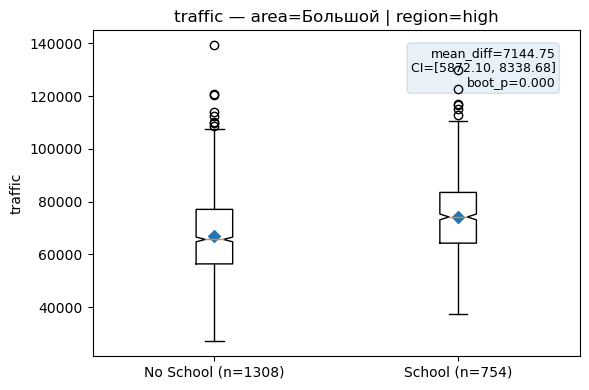

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


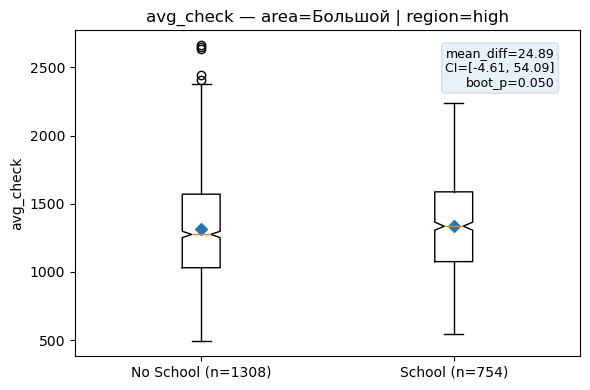

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


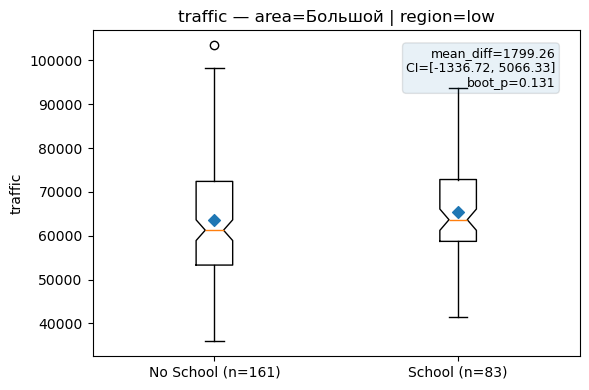

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


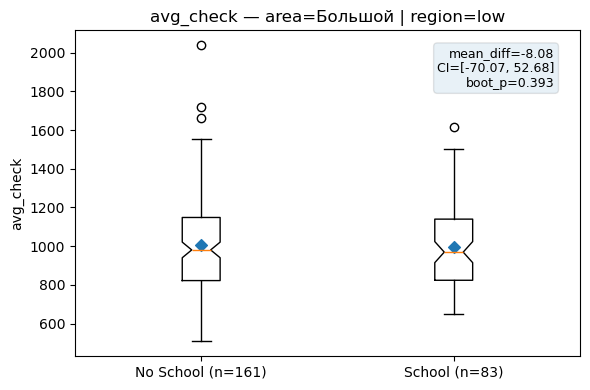

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


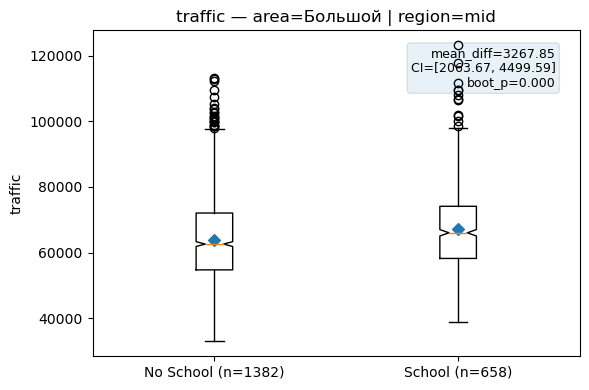

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


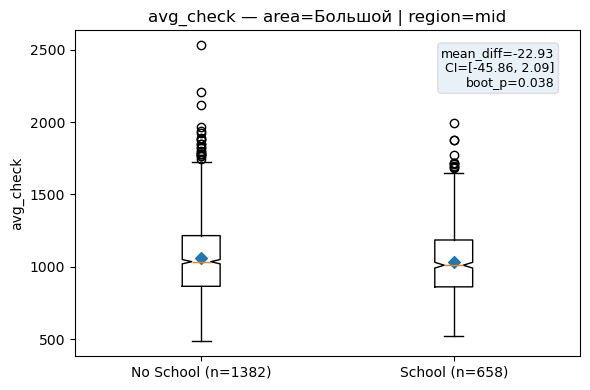

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


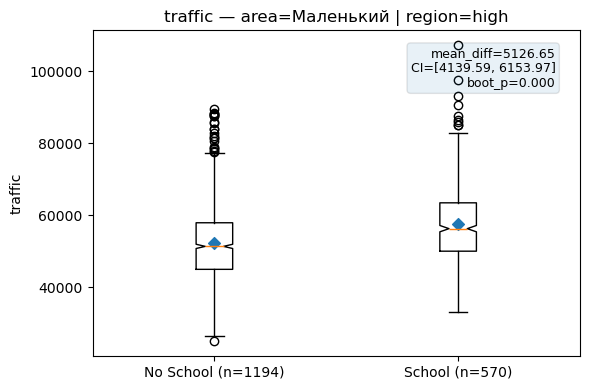

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


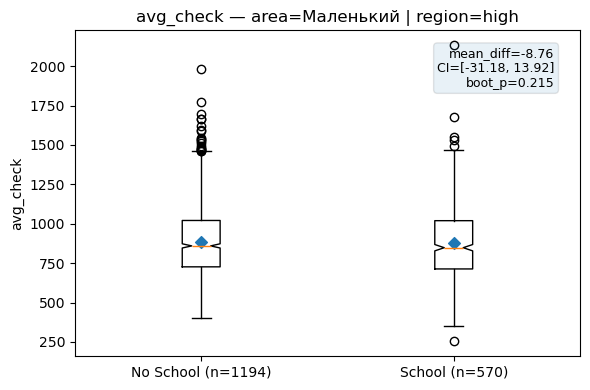

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


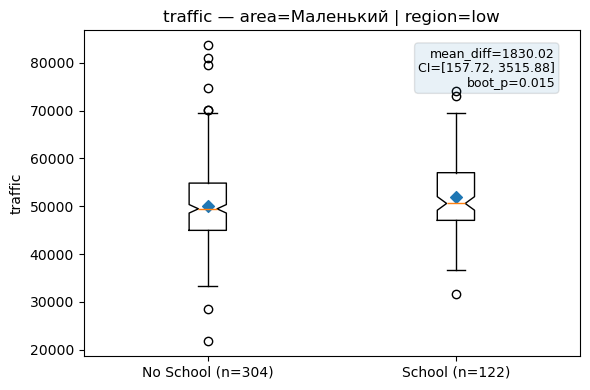

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


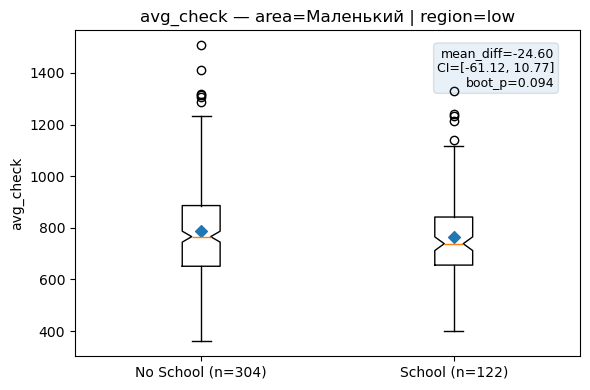

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


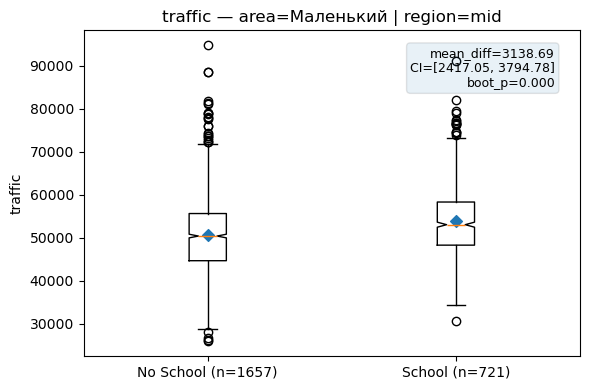

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


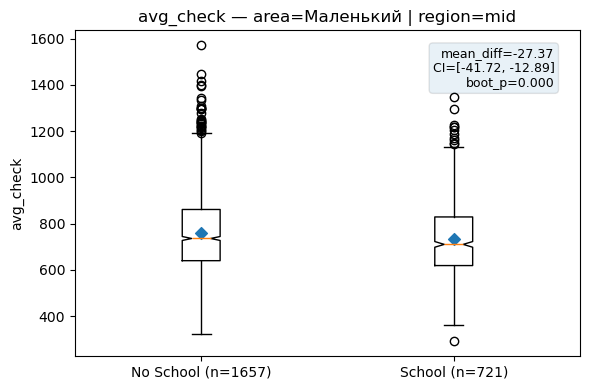

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


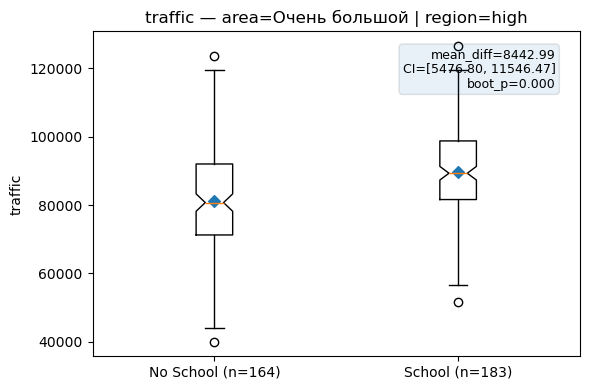

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


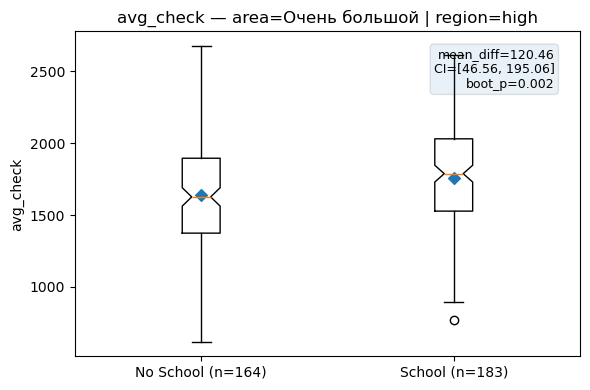

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


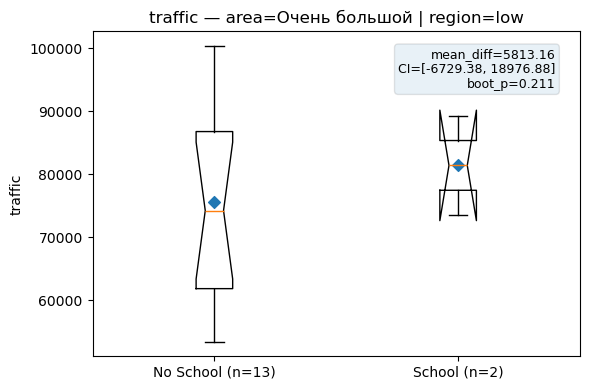

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


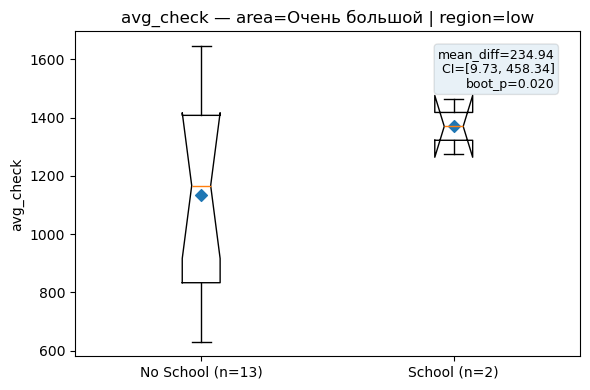

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


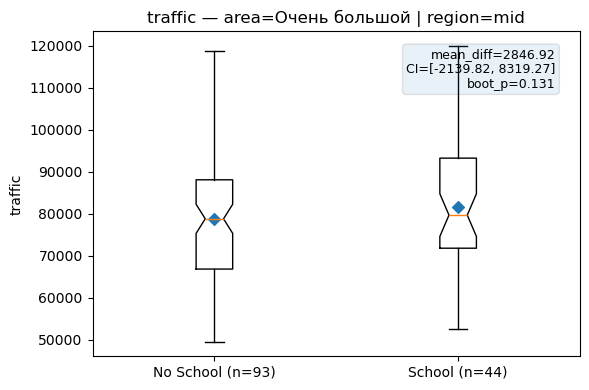

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


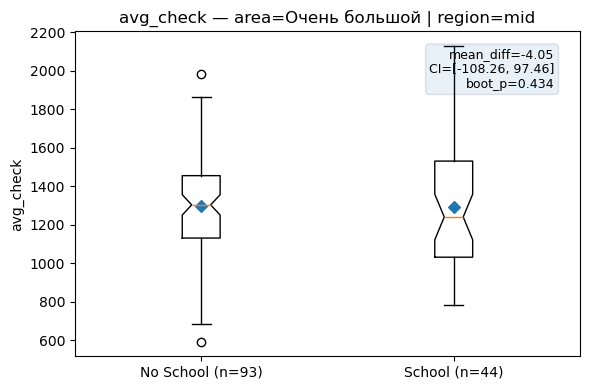

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


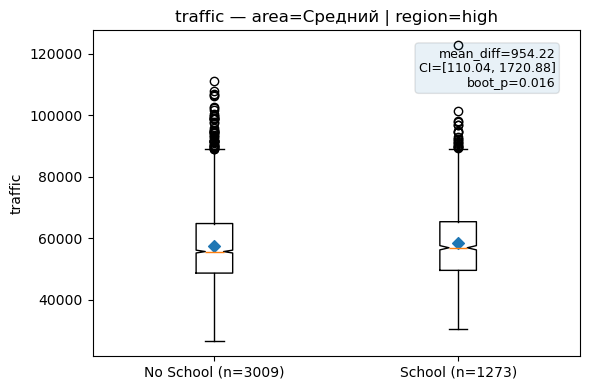

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


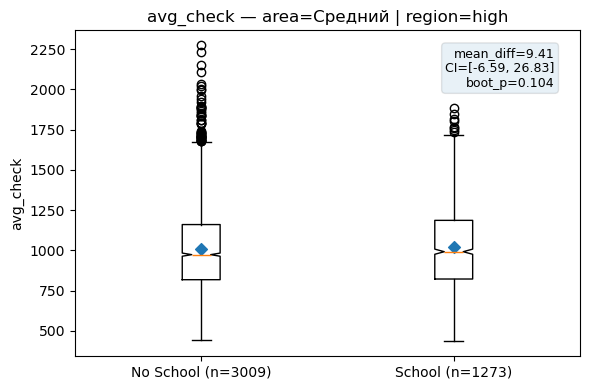

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


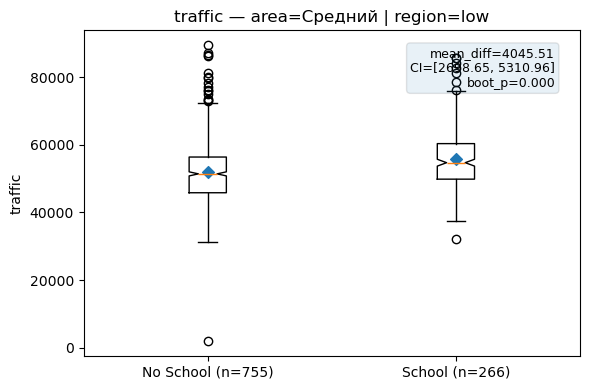

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


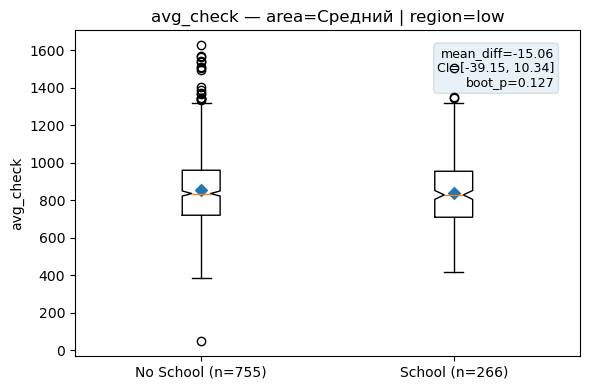

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


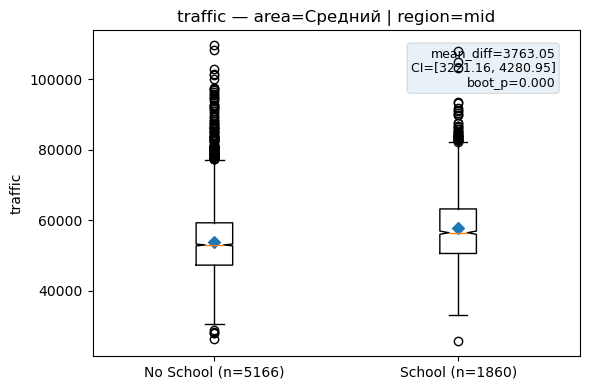

C:\Users\egor_\AppData\Local\Temp\ipykernel_18752\2092288226.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=labels, notch=True, patch_artist=False)


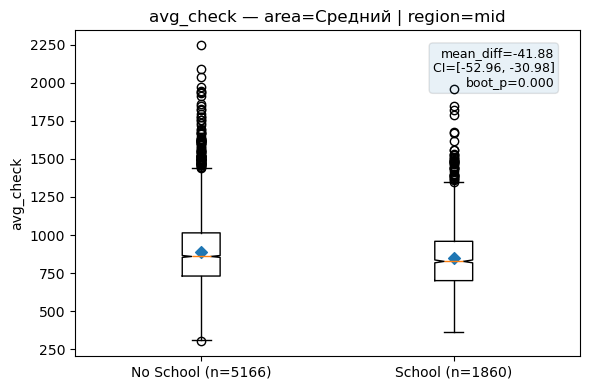

       area_group region_index_group  n_total  n_schools  n_no_schools  \
0         Большой               high     2062        754          1308   
1         Большой                low      244         83           161   
2         Большой                mid     2040        658          1382   
3       Маленький               high     1764        570          1194   
4       Маленький                low      426        122           304   
5       Маленький                mid     2378        721          1657   
6   Очень большой               high      347        183           164   
7   Очень большой                low       15          2            13   
8   Очень большой                mid      137         44            93   
9         Средний               high     4282       1273          3009   
10        Средний                low     1021        266           755   
11        Средний                mid     7026       1860          5166   

    traffic_mean1  traffic_mean0  tra

In [17]:
results_df, regressions = run_robustness_check(df, n_boot=2000, min_n=4, plot=True, robust=True)
#
print(results_df)
print(regressions['traffic'].summary())
print(regressions['avg_check'].summary())
#
# You can also run prepare_data(df, is_season_flag=True) separately to inspect df_store.